In [1]:
%config IPCompleter.greedy=True

## Variational Autoencoder (VAE)
A tutorial with code for a VAE as described in [Kingma and Welling, 2013](http://arxiv.org/abs/1312.6114). A talk with more details was given at the [DataLab Brown Bag Seminar](https://home.zhaw.ch/~dueo/bbs/files/vae.pdf).

Much of the code was taken, from https://jmetzen.github.io/2015-11-27/vae.html. However, I tried to focus more on the mathematical understanding, not so much on design of the algorithm.

### Some theoretical considerations 

#### Outline
Situation: $x$ is from a high-dimensional space and $z$ is from a low-dimensional (latent) space, from which we like to reconstruct $p(x)$. 

We consider a parameterized model $p_\theta(x|z)$ (with parameter $\theta$), to construct x for a given value of $z$. We build this model: 

* $p_\theta(x | z)$ with a neural network determening the parameters $\mu, \Sigma$ of a Gaussian (or as done here with a Bernoulli-Density). 

#### Inverting $p_\theta(x | z)$

The inversion is not possible, we therefore approximate $p(z|x)$ by $q_\phi (z|x)$ again a combination of a NN determening the parameters of a Gaussian

* $q_\phi(z | x)$ with a neural network + Gaussian 

#### Training

We train the network treating it as an autoencoder. 

#### Lower bound of the Log-Likelihood
The likelihood cannot be determined analytically. Therefore, in a first step we derive a lower (variational) bound $L^{v}$ of the log likelihood, for a given image. Technically we assume a discrete latent space. For a continous case simply replace the sum by the appropriate integral over the respective densities. We replace the inaccessible conditional propability $p(z|x)$ with an approximation $q(z|x)$ for which we later use a neural network topped by a Gaussian.

\begin{align}
L & = \log\left(p(x)\right) &\\
  & = \sum_z q(z|x) \; \log\left(p(x)\right) &\text{multiplied with 1 }\\
  & = \sum_z q(z|x) \; \log\left(\frac{p(z,x)}{p(z|x)}\right) &\\
  & = \sum_z q(z|x) \; \log\left(\frac{p(z,x)}{q(z|x)} \frac{q(z|x)}{p(z|x)}\right) &\\
  & = \sum_z q(z|x) \; \log\left(\frac{p(z,x)}{q(z|x)}\right) + \sum_z q(z|x) \; \log\left(\frac{q(z|x)}{p(z|x)}\right) &\\
  & = L^{\tt{v}} + D_{\tt{KL}} \left( q(z|x) || p(z|x) \right) &\\
  & \ge L^{\tt{v}} \\
\end{align}

The KL-Divergence $D_{\tt{KL}}$ is always positive, and the smaller the better $q(z|x)$ approximates $p(z|x)$


### Rewritting  $L^\tt{v}$
We split $L^\tt{v}$ into two parts.

\begin{align}
L^{\tt{v}} & = \sum_z q(z|x) \; \log\left(\frac{p(z,x)}{q(z|x)}\right)  & \text{with} \;\;p(z,x) = p(x|z) \,p(z)\\
  & =  \sum_z q(z|x) \; \log\left(\frac{p(x|z) p(z)}{q(z|x)}\right)  &\\
  & =  \sum_z q(z|x) \; \log\left(\frac{p(z)}{q(z|x)}\right)  + \sum_z q(z|x) \; \log\left(p(x|z)\right) &\\
  & =  -D_{\tt{KL}} \left( q(z|x) || p(z) \right)  +  \mathbb{E}_{q(z|x)}\left( \log\left(p(x|z)\right)\right) &\text{putting in } x^{(i)} \text{ for } x\\
  & =  -D_{\tt{KL}} \left( q(z|x^{(i)}) || p(z) \right)  +  \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right) &\\
\end{align}

Approximating $\mathbb{E}_{q(z|x^{(i)})}$ with sampling form the distribution $q(z|x^{(i)})$

#### Sampling 
With $z^{(i,l)}$ $l = 1,2,\ldots L$ sampled from $z^{(i,l)} \thicksim q(z|x^{(i)})$
\begin{align}
L^{\tt{v}} & = -D_{\tt{KL}} \left( q(z|x^{(i)}) || p(z) \right)  
+  \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right) &\\
L^{\tt{v}} & \approx -D_{\tt{KL}} \left( q(z|x^{(i)}) || p(z) \right)  
+  \frac{1}{L} \sum_{i=1}^L \log\left(p(x^{(i)}|z^{(i,l)})\right) &\\
\end{align}

#### Calculation of $D_{\tt{KL}} \left( q(z|x^{(i)}) || p(z) \right)$
TODO

In [2]:
#adhere to https://github.com/tensorflow/tensorflow/blob/r0.7/tensorflow/examples/tutorials/mnist/input_data.py

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import weapon_data as weapons
import matplotlib.pyplot as plt
%matplotlib inline

print("Tensor Flow version {}".format(tf.__version__))

D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor Flow version 1.8.0


In [3]:
weapon_data = weapons.DataSet(seed=19071991) 

num_samples = weapon_data.num_examples

#training params
learning_rate = 0.01
num_epochs = 10
batch_size = 10
epoch_debug_step = 1

#network params
input_dim = weapon_data.num_features
hidden_1_dim = 14
hidden_2_dim = 15 #one more to spot errors
z_dim = 2 #Dimension of the latent space

In [4]:
# Functions to get variables
def create_weight(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)
    initial = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initial(shape))

def create_bias(shape):
    initial = tf.constant(0.1, shape=shape)
    #initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)
    initial = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initial(shape))

### Building the networks
#### The encoder network $q_\phi(z|x)$

The decoder network takes the input image and calculates the mean $\mu =$ `z_mu` and the log variance $\log(\sigma^2) =$ `z_ls2` of the Gaussian, thus producing the latent variable z.

##### Why $\log(\sigma^2)$ instead of the variance $\sigma^2$ ?
The variance $\sigma^2$ is always > 0 and we don't want to enforce that the network only produces positive numbers. Therefore, we let the network model the parameter $\log(\sigma^2) \in [\infty, \infty]$

In [5]:
# Variables
weight = {
    'encoder_h1': create_weight([input_dim, hidden_1_dim]),
    'encoder_h2': create_weight([hidden_1_dim, hidden_2_dim]),
    'z_mean': create_weight([hidden_2_dim, z_dim]),
    'z_ls2': create_weight([hidden_2_dim, z_dim]),
    'decoder_h1': create_weight([z_dim, hidden_1_dim]),
    'decoder_h2': create_weight([hidden_1_dim, hidden_2_dim]),
    'decoder_out': create_weight([hidden_2_dim, input_dim])
}
bias = {
    'encoder_h1': create_bias([hidden_1_dim]),
    'encoder_h2': create_bias([hidden_2_dim]),
    'z_mean': create_bias([z_dim]),
    'z_ls2': create_bias([z_dim]),
    'decoder_h1': create_bias([hidden_1_dim]),
    'decoder_h2': create_bias([hidden_2_dim]),
    'decoder_out': create_bias([input_dim])
}

# Input
x = tf.placeholder(tf.float32, shape=[None, input_dim]) 

# First hidden layer
encoder_h1 = tf.matmul(x, weight['encoder_h1']) + bias['encoder_h1']
encoder_h1 = tf.nn.tanh(encoder_h1)

# Second hidden layer
encoder_h2 = tf.matmul(encoder_h1, weight['encoder_h2']) + bias['encoder_h2']
encoder_h2 = tf.nn.tanh(encoder_h2)

# Parameters for the Gaussian
z_mu = tf.matmul(encoder_h2, weight['z_mean']) + bias['z_mean']
z_ls2 = tf.matmul(encoder_h2, weight['z_ls2']) + bias['z_ls2']

#### The decoder network $p_\theta(x|z)$ a.k.a. generator network

Samples from a Gaussian using the given mean and the std. The sampling is done by addding a random number ensuring that backpropagation works fine.

In [6]:
# Adding a random number from the normal (gaussian) distribution
epsilon = tf.random_normal((batch_size, z_dim), 0, 1, dtype=tf.float32) 

# sample z from a normal (gaussian) distribution
z = z_mu + tf.multiply(tf.sqrt(tf.exp(z_ls2)), epsilon)

In [7]:
def decoder_op(z_input):
    decoder_h1 = tf.matmul(z_input, weight['decoder_h1']) + bias['decoder_h1']
    decoder_h1 = tf.nn.tanh(decoder_h1)

    decoder_h2 = tf.matmul(decoder_h1, weight['decoder_h2']) + bias['decoder_h2']
    decoder_h2 = tf.nn.tanh(decoder_h2)
    
    x_reconstr = tf.matmul(decoder_h2,  weight['decoder_out']) + bias['decoder_out']
    #x_reconstr = tf.nn.sigmoid(x_reconstr)
    return x_reconstr

decoder = decoder_op(z)

#### Defining the loss function

##### The reconstruction error
We assume that the data x, is Gaussian distributed with diagnoal covariance matrix $\Sigma_{ij} = \delta_{i,j} \sigma_i^2$. The parameters of that Gaussian are determined by the encoder network. The reconstruction error for the $i-th$ example in the min-batch is given by 
$$
    \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right) 
$$
we approximate the expectation with samplinging from the distribution (eaven with $L=1$)
$$
    \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right) \approx 
    \frac{1}{L} \sum_{i=1}^L \log\left(p(x^{(i)}|z^{(i,l)})\right) \approx \log\left(p(x^{(i)}|z^{(i,l)})\right)
$$

For the simple $J-dimensional$ Gaussian, we obtain the following reconstruction error (neglegting a constant term)
$$
    -\log\left(p(x^{(i)}|z^{(i)})\right) = \sum_{j=1}^D \frac{1}{2} \log(\sigma_{x_j}^2) + \frac{(x^{(i)}_j - \mu_{x_j})^2}{2 \sigma_{x_j}^2}
$$

##### The regularisation term

$$
    -D_{\tt{KL}} \left( q(z|x^{(i)}) || p(z) \right) = \frac{1}{2} \sum_{j=1}^{J} \left(1 + \log(\sigma_{z_j}^{(i)^2}) - \mu_{z_j}^{(i)^2} - \sigma_{z_j}^{(i)^2} \right)
$$

In [8]:
def kullbackLeibler(mu, log_sigma):
    """(Gaussian) Kullback-Leibler divergence KL(q||p), per training example"""
    # (tf.Tensor, tf.Tensor) -> tf.Tensor
    with tf.name_scope("KL_divergence"):
        # = -0.5 * (1 + log(sigma**2) - mu**2 - sigma**2)
        return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 -
                                    tf.exp(2 * log_sigma), 1)

def crossEntropy(obs, actual, offset=1e-7):
    """Binary cross-entropy, per training example"""
    # (tf.Tensor, tf.Tensor, float) -> tf.Tensor
    with tf.name_scope("cross_entropy"):
        # bound by clipping to avoid nan (--> log(0))
        obs_ = tf.clip_by_value(obs, offset, 1 - offset)
    return -tf.reduce_sum(actual * tf.log(obs_) + (1 - actual) * tf.log(1 - obs_), 1)

def l1_loss(obs, actual):
    """L1 loss (a.k.a. LAD), per training example"""
    # (tf.Tensor, tf.Tensor, float) -> tf.Tensor
    with tf.name_scope("l1_loss"):
        return tf.reduce_sum(tf.abs(obs - actual) , 1)

def l2_loss(obs, actual):
    """L2 loss (a.k.a. Euclidean / LSE), per training example"""
    # (tf.Tensor, tf.Tensor, float) -> tf.Tensor
    with tf.name_scope("l2_loss"):
        return tf.reduce_sum(tf.square(obs - actual), 1)

In [9]:
#according to the VAE tutorial paper:
reconstr_loss = tf.reduce_sum(tf.square(tf.abs(x - decoder)), 1)

#reconstr_loss = l2_loss(decoder, x)
#reconstr_loss = crossEntropy(decoder, x)

 
latent_loss = kullbackLeibler(z_mu, tf.log(tf.sqrt(tf.exp(z_ls2))))

cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch

# Use ADAM optimizer
#optimizer =  tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer =  tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)


In [10]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

if False:
    while False:
        sess = tf.Session()  
        sess.run(init)
        batch_xs = next_batch(batch_size)
        dd = sess.run([cost], feed_dict={x: batch_xs})
        print('Test run of cost operation in while loop results in {}'.format(dd))
        if not np.isnan(dd) and not np.isinf(dd):
            break
        else:
            sess.close()
            
        
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(num_epochs):
        avg_cost = 0.
        total_batch = int(num_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs = weapon_data.next_batch(batch_size)
            _, d, z_mean_val, z_log_sigma_sq_val = sess.run((optimizer, cost,  z_mu, z_ls2), feed_dict={x: batch_xs})
            avg_cost += d / num_samples * batch_size

        # Display logs per epoch step
        if epoch % epoch_debug_step == 0:
            save_path = saver.save(sess, "weapon_data_model/vae.ckpt") #Saves the weights (not the graph)
            #print("Model saved in file: {}".format(save_path))
            print("Epoch:"+ '%04d' % (epoch+1) + ", cost=" + "{:.9f}".format(avg_cost))
            #print ("{} {} mean sigma2 {}".format(z_mean_val.min(), z_mean_val.max(), np.mean(np.exp(z_log_sigma_sq_val))))



Epoch:0001, cost=23.101199511
Epoch:0002, cost=23.153032870
Epoch:0003, cost=22.839189220
Epoch:0004, cost=22.284894892
Epoch:0005, cost=22.889265370
Epoch:0006, cost=19.916324229
Epoch:0007, cost=20.131305488
Epoch:0008, cost=19.501154938
Epoch:0009, cost=17.799623721
Epoch:0010, cost=18.199885729


In [11]:
def print_decoded_tensors_as_dict(weapon_data, array_of_tensors):
    genDict = {}
    
    for tensor in array_of_tensors:
        decoded = weapon_data.decode_processed_tensor(tensor)
        
        for key, value in decoded.items():
            if key not in genDict:
                genDict[key] = []
            genDict[key].append(value)
    
    for key, value in genDict.items():
            print(key, "=", value)
        
        
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "weapon_data_model/vae.ckpt")
    
    samples = weapon_data.next_batch(batch_size)
    reconstruction = sess.run(decoder, feed_dict={x: samples})
    
    print(samples)
    print(reconstruction)
    
    print_decoded_tensors_as_dict(weapon_data, np.concatenate((samples, reconstruction), axis=0))
    
    mean, variance = sess.run((tf.reduce_mean(z_mu), tf.reduce_mean(tf.sqrt(tf.exp(z_ls2)))), feed_dict={x: samples})
    print("latent mean = %f, latent variance = %f "%(mean, variance))


INFO:tensorflow:Restoring parameters from weapon_data_model/vae.ckpt
[[-1.26885166e+00 -1.06003774e+00 -9.97778024e-02 -9.93695305e-01
   3.49562516e+00 -7.69023959e-01 -7.57936729e-01  1.67178701e+00
  -9.06016537e-01  1.03961711e+00  2.97535578e+00  3.17360952e+00
  -1.20156256e+00 -4.83999063e-01 -2.46162033e-03 -1.11984876e+00
   3.52767706e+00  3.09377255e+00 -5.04219484e-01 -5.46118681e-01
  -3.60237411e-01 -5.25225731e-01 -4.06637837e-01  3.50957490e+00]
 [-1.40620805e+00 -1.13091727e+00 -9.97778024e-02 -9.93695305e-01
   3.49562516e+00 -7.69023959e-01  1.31937134e+00 -5.98162323e-01
  -3.56116951e-01 -2.30238568e-01  1.19690834e+00  2.78987253e+00
  -1.20156256e+00 -5.07500330e-01 -1.88251314e-01 -7.36332643e-01
   3.52767706e+00  3.09377255e+00 -5.04219484e-01 -5.46118681e-01
  -3.60237411e-01 -5.25225731e-01 -4.06637837e-01  3.08992881e+00]
 [-5.61870144e-01 -6.95216633e-01 -2.14830501e-01 -7.11685557e-01
  -2.23362650e-01 -7.69023959e-01  1.31937134e+00 -5.98162323e-01
  -1.

latent mean = -0.002970, latent variance = 0.700636 


In [12]:
'''with tf.Session() as sess:
    
    saver.restore(sess, "weapon_data_model/vae.ckpt")
    samples = weapon_data.next_batch(batch_size)

    z_vals,z_mean_val,z_log_sigma_sq_val  = sess.run((z, z_mu, z_ls2), feed_dict={x: samples})

       
    plt.figure(figsize=(8, 12))
    for i in range(batch_size):
        #plt.colorbar()
        plt.subplot(5, 3, 1*i+1)
        plt.scatter(z_vals[:,0],z_vals[:,1], c='gray', alpha=0.5)
        plt.scatter(z_mean_val[i,0],z_mean_val[i,1], c='green', s=64, alpha=0.5)
        plt.scatter(z_vals[i,0],z_vals[i,1], c='blue', s=16, alpha=0.5)

        plt.xlim((-3,3))
        plt.ylim((-3,3))
        plt.title("Latent Space")
        
                
        

    plt.tight_layout()
    
'''    

'with tf.Session() as sess:\n    \n    saver.restore(sess, "weapon_data_model/vae.ckpt")\n    samples = weapon_data.next_batch(batch_size)\n\n    z_vals,z_mean_val,z_log_sigma_sq_val  = sess.run((z, z_mu, z_ls2), feed_dict={x: samples})\n\n       \n    plt.figure(figsize=(8, 12))\n    for i in range(batch_size):\n        #plt.colorbar()\n        plt.subplot(5, 3, 1*i+1)\n        plt.scatter(z_vals[:,0],z_vals[:,1], c=\'gray\', alpha=0.5)\n        plt.scatter(z_mean_val[i,0],z_mean_val[i,1], c=\'green\', s=64, alpha=0.5)\n        plt.scatter(z_vals[i,0],z_vals[i,1], c=\'blue\', s=16, alpha=0.5)\n\n        plt.xlim((-3,3))\n        plt.ylim((-3,3))\n        plt.title("Latent Space")\n        \n                \n        \n\n    plt.tight_layout()\n    \n'

In [13]:

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf


saver = tf.train.Saver()
all_z = np.zeros((1,z_dim))
with tf.Session() as sess:
    saver.restore(sess, "weapon_data_model/vae.ckpt")
    total_batch = int(num_samples / batch_size) 
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = weapon_data.next_batch(batch_size)
        x_reconstruct,z_vals,z_mean_val,z_log_sigma_sq_val  = \
        sess.run((decoder,z, z_mu, z_ls2), feed_dict={x: batch_xs})
        all_z = np.vstack((all_z, z_mean_val))

        


INFO:tensorflow:Restoring parameters from weapon_data_model/vae.ckpt


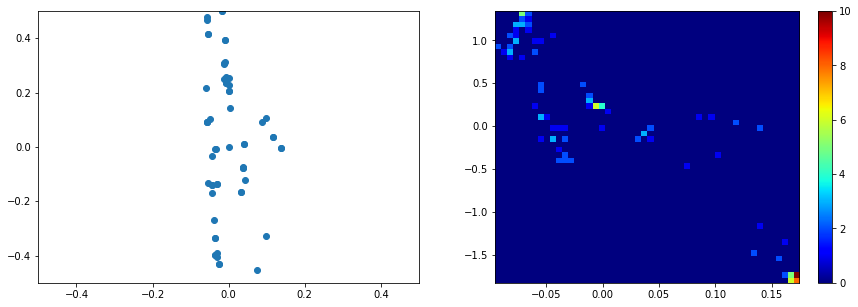

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(all_z[:,0], all_z[:,1])
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.subplot(1,2,2)
plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
plt.colorbar()


In [15]:
# Testing
random = tf.random_uniform(shape=[1,z_dim], minval=-100.0, maxval=100.0)
noise_input = tf.placeholder(tf.float32, shape=[None, z_dim])
test_decoder = decoder_op(noise_input)
    
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    generated = []
    for i in range(4):
        random_val = sess.run(random)
        x_test = sess.run(test_decoder, feed_dict={noise_input: random_val})
        generated.append(x_test[0])
    print_decoded_tensors_as_dict(weapon_data, generated)

damages_first = ['48.29551521768009', '42.18603815165434', '47.46281729285136', '44.25278920029045']
damages_last = ['36.132469647343896', '32.70516719530477', '33.64063408937731', '35.49243171020498']
dmg_distances_first = ['15.225219886146531', '18.353926909124645', '18.01292334405192', '16.482774292126916']
dmg_distances_last = ['62.04263638612591', '67.3831100250691', '68.0045510915293', '62.95914536335892']
drag = ['0.0028970229754082576', '0.0027851430227998158', '0.002649860078314396', '0.002937896760639021']
firemode_Automatic = ['0.4045583467153074', '0.3919891459588974', '0.4300927998554176', '0.40011999204064175']
firemode_Semi-Automatic = ['0.38064463327099374', '0.440666582910674', '0.47962308679163607', '0.3589528971465606']
hiprecoildec = ['5.558184483620075', '5.925943182791487', '5.853946538413455', '5.7240846297644286']
hiprecoilright = ['0.6643541192738012', '0.5831004080183583', '0.5817741536910277', '0.6440119513926054']
hiprecoilup = ['2.9103469907295065', '2.8680